# **L4 Fairness**

Taylor Sullivan (tsulliva) 

Link to code: 
[Colab Notebook](https://colab.research.google.com/drive/1xXDSBJHzmZbWjoDIqlAN6UWmZ5xDuVJg?usp=sharing)

**Task 1**: *Train Credit Scoring Model*: Train a credit scoring model based on part of the labeled sample data (technically, this would be a global surrogate model, but for the purpose of this assignment we are assuming that the labels correspond to people actually defaulting on the loan) – pretty much any supervised classification model that comes with customizable thresholds will do. Evaluate the quality of your model with the remaining data and plot an ROC curve. Typical solutions will achieve an ROC_AUC of around 0.7.

We intend this to be easy; it is just a necessary step to produce a model you can work with. You may reuse existing code you find online for this task. For example, we recommend the following Kaggle notebook, although you are free to use any other code, as long as you credit the source.

**Reference**: I adapted the following Kaggle notebook to develop the model and train it: 
[Kaggle Notebook Link](https://www.kaggle.com/code/kabure/predicting-credit-risk-model-pipeline/notebook)

I used the grid search optimization technique and XGBclassifier technique mentioned after the 2nd model that the author developed in the Kaggle dataset

**Accuracy**: .784*

*Calculated on .25 of dataset, which was held out for testing purposes*


**ROC curve** can be found below as well.

In [30]:
!pip install aif360
!pip install fairlearn
!pip install lime 

In [230]:
#Import necessary packages 

import pandas as pd 
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
import numpy as np
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../')
import numpy as np

%matplotlib inline
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns 

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.sklearn import metrics

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

In [204]:
# Create Dataframe in Pandas and assign headers 

df_credit = pd.read_csv("german.data", header=None, delimiter=" ")
df_credit = df_credit.rename(columns={0: 'Status of existing checking account', 
                                      1: 'Duration in month', 
                                      2:'Credit history', 
                                      3:'Purpose', 
                                      4:'Credit amount', 
                                      5:'Savings account/bonds', 
                                      6: 'Present employment since',
                                      7:'Installment rate in percentage of disposable income', 
                                      8:'Personal status and sex', 
                                      9:'Other debtors / guarantors', 
                                      10:'Present residence since', 
                                      11:'Property', 
                                      12:'Age in years', 
                                      13:'Other installment plans', 
                                      14:'Housing', 
                                      15:'Number of existing credits at this bank', 
                                      16:'Job', 
                                      17:'Number of people being liable to provide maintenance for', 
                                      18:'Telephone', 
                                      19:'foreign worker', 
                                      20:'Y'})

In [205]:
# Three categories are Male and One is Female 
df_credit['Personal status and sex'].unique()

array(['A93', 'A92', 'A91', 'A94'], dtype=object)

In [206]:
# Categorize age variable in accordance with Kaggle solution: 

interval = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit['Age in years'], interval, labels=cats)

In [207]:
#Create Dummy Variables

#Status of existing checking account to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Status of existing checking account'], drop_first=True, prefix='Status of existing checking account'), left_index=True, right_index=True)
#Credit history to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Credit history'], drop_first=True, prefix='Credit history'), left_index=True, right_index=True)
#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Purpose'], drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Savings account/bonds to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Savings account/bonds'], drop_first=True, prefix='Savings account/bonds'), left_index=True, right_index=True)
#Present employment since to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Present employment since'], drop_first=True, prefix='Present employment since'), left_index=True, right_index=True)
#Personal status and sex to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Personal status and sex'], drop_first=True, prefix='Personal status and sex'), left_index=True, right_index=True)
#Property to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Property, drop_first=True, prefix='Property'), left_index=True, right_index=True)
#Other installment plans to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other installment plans'], drop_first=True, prefix='Other installment plans'), left_index=True, right_index=True)
#Housing to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
#Job to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Job, drop_first=True, prefix='Job'), left_index=True, right_index=True)
#Telephone to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Telephone, drop_first=True, prefix='Telephone'), left_index=True, right_index=True)
#foreign worker to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['foreign worker'], drop_first=True, prefix='foreign worker'), left_index=True, right_index=True)
# 'Other debtors / guarantors' to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other debtors / guarantors'], drop_first=True, prefix='Other debtors / guarantors'), left_index=True, right_index=True)
# 'Other installment plans' to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other installment plans'], drop_first=True, prefix='Other installment plans'), left_index=True, right_index=True)
# df_credit["Age_cat"] to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Age_cat'], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)
# df_credit["Y"] to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Y'], drop_first=True, prefix='Y'), left_index=True, right_index=True)

In [208]:
#Separate out Y values
y = df_credit.Y_2

In [209]:
#Remove now-redundant columns 

del df_credit['foreign worker']
del df_credit['Telephone']
del df_credit['Job']
del df_credit['Housing']
del df_credit['Property']
del df_credit['Personal status and sex']
del df_credit['Present employment since']
del df_credit['Savings account/bonds']
del df_credit['Purpose']
del df_credit['Credit history']
del df_credit['Status of existing checking account']
del df_credit['Other debtors / guarantors']
del df_credit['Other installment plans']
del df_credit['Age_cat']
del df_credit['Age in years']
del df_credit['Y']
del df_credit['Y_2']

In [210]:
df_credit

,Duration in month,Credit amount,Installment rate in percentage of disposable income,Present residence since,Number of existing credits at this bank,Number of people being liable to provide maintenance for,Status of existing checking account_A12,Status of existing checking account_A13,Status of existing checking account_A14,Credit history_A31,...,Job_A174,Telephone_A192,foreign worker_A202,Other debtors / guarantors_A102,Other debtors / guarantors_A103,Other installment plans_A142_y,Other installment plans_A143_y,Age_cat_Young,Age_cat_Adult,Age_cat_Senior
0,6,1169,4,4,2,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,48,5951,2,2,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,12,2096,2,3,1,2,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
3,42,7882,2,4,1,2,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
4,24,4870,3,4,2,2,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,1,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
996,30,3857,4,4,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
997,12,804,4,4,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
998,45,1845,4,4,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


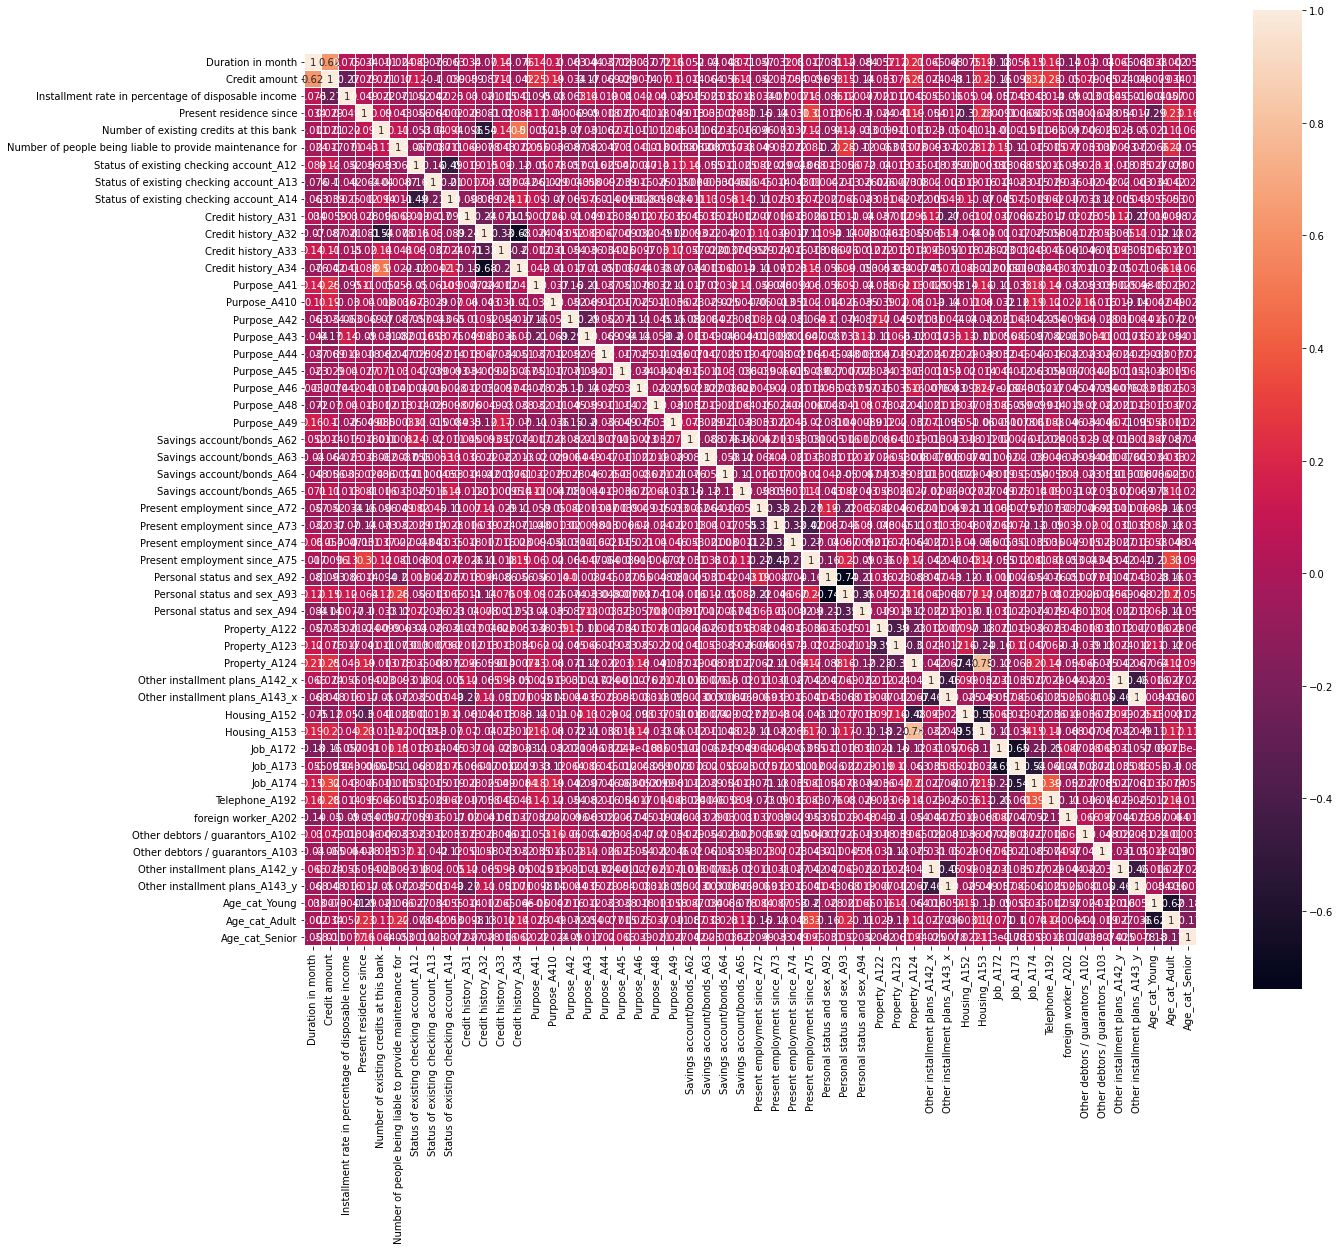

In [211]:
#Determine correlated features 
plt.figure(figsize=(20,18))
sns.heatmap(df_credit.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [212]:
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])

#Creating the X and y variables
X = df_credit.values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [162]:
#Seting the Hyper Parameters
param_test1 = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

#Creating the classifier
model_xg = XGBClassifier(random_state=2)

grid_search = GridSearchCV(model_xg, param_grid=param_test1, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(random_state=2),
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': [3, 5, 6, 10],
                         'min_child_weight': [3, 5, 10],
                         'subsample': [0.75, 0.8, 0.85]},
             scoring='recall')

In [163]:
grid_search.best_score_
grid_search.best_params_

{'colsample_bytree': 0.75,
 'gamma': 0.2,
 'max_depth': 5,
 'min_child_weight': 3,
 'subsample': 0.75}

In [164]:
# Printing the Training Score
print("Training score data: ")
print(grid_search.score(X_train, y_train))

Training score data: 
0.8026315789473685


In [165]:
y_pred = grid_search.predict(X_test)

# Verificaar os resultados obtidos
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))

0.756


[[155  23]
 [ 38  34]]


In [166]:
#Predicting proba
y_pred_prob = grid_search.predict_proba(X_test)[:,1]

y_test2 = pd.get_dummies(y_test, drop_first=True, prefix='y_test')

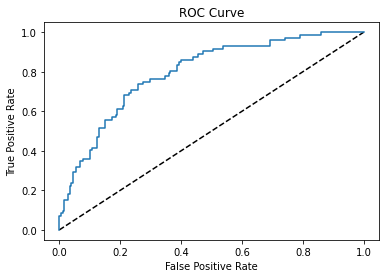

In [167]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test2, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

**Task 2**: *Measuring fairness*: Consider gender and age as protected attributes and assume that the labels in the validation data are an accurate reflection of that person’s risk of defaulting on a loan. For each protected attribute evaluate the fairness of your model using (a) anti-classification, (b) group fairness, and (c) separation as the fairness criteria. If you need to make assumptions (e.g., select thresholds) state your assumptions.

You may use existing tools like IBM’s AI Fairness 360 toolkit, but it might be easier to implement this yourself and derive measures directly from tests and the confusion matrix.

**Anti-classification Testing:**

In [184]:
#Determine Rows that are the same except for age and gender and see if there are cases in which there is a difference in predictions 
#First with the test set 
df_test = pd.DataFrame(X_test, columns = ['Duration in month', 'Credit amount',
       'Installment rate in percentage of disposable income',
       'Present residence since', 'Number of existing credits at this bank',
       'Number of people being liable to provide maintenance for',
       'Status of existing checking account_A12',
       'Status of existing checking account_A13',
       'Status of existing checking account_A14', 'Credit history_A31',
       'Credit history_A32', 'Credit history_A33', 'Credit history_A34',
       'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43',
       'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48',
       'Purpose_A49', 'Savings account/bonds_A62', 'Savings account/bonds_A63',
       'Savings account/bonds_A64', 'Savings account/bonds_A65',
       'Present employment since_A72', 'Present employment since_A73',
       'Present employment since_A74', 'Present employment since_A75',
       'Personal status and sex_A92', 'Personal status and sex_A93',
       'Personal status and sex_A94', 'Property_A122', 'Property_A123',
       'Property_A124', 'Other installment plans_A142_x',
       'Other installment plans_A143_x', 'Housing_A152', 'Housing_A153',
       'Job_A172', 'Job_A173', 'Job_A174', 'Telephone_A192',
       'foreign worker_A202', 'Other debtors / guarantors_A102',
       'Other debtors / guarantors_A103', 'Other installment plans_A142_y',
       'Other installment plans_A143_y', 'Age_cat_Young', 'Age_cat_Adult',
       'Age_cat_Senior'])
df_test = df_test.drop(['Personal status and sex_A92', 'Personal status and sex_A93',
       'Personal status and sex_A94', 'Age_cat_Young', 'Age_cat_Adult',
       'Age_cat_Senior'], axis=1)
ind = df_test.duplicated()
df_test[ind]
#There are no cases in the training set in which there are participants with the same data except race or gender 

#DI tried the same method with the train set  
df_train = pd.DataFrame(X_train, columns = ['Duration in month', 'Credit amount',
       'Installment rate in percentage of disposable income',
       'Present residence since', 'Number of existing credits at this bank',
       'Number of people being liable to provide maintenance for',
       'Status of existing checking account_A12',
       'Status of existing checking account_A13',
       'Status of existing checking account_A14', 'Credit history_A31',
       'Credit history_A32', 'Credit history_A33', 'Credit history_A34',
       'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43',
       'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48',
       'Purpose_A49', 'Savings account/bonds_A62', 'Savings account/bonds_A63',
       'Savings account/bonds_A64', 'Savings account/bonds_A65',
       'Present employment since_A72', 'Present employment since_A73',
       'Present employment since_A74', 'Present employment since_A75',
       'Personal status and sex_A92', 'Personal status and sex_A93',
       'Personal status and sex_A94', 'Property_A122', 'Property_A123',
       'Property_A124', 'Other installment plans_A142_x',
       'Other installment plans_A143_x', 'Housing_A152', 'Housing_A153',
       'Job_A172', 'Job_A173', 'Job_A174', 'Telephone_A192',
       'foreign worker_A202', 'Other debtors / guarantors_A102',
       'Other debtors / guarantors_A103', 'Other installment plans_A142_y',
       'Other installment plans_A143_y', 'Age_cat_Young', 'Age_cat_Adult',
       'Age_cat_Senior'])
df_train = df_train.drop(['Personal status and sex_A92', 'Personal status and sex_A93',
       'Personal status and sex_A94', 'Age_cat_Young', 'Age_cat_Adult',
       'Age_cat_Senior'], axis=1)
ind2 = df_train.duplicated()
df_train[ind2]
#There are no cases in the training set in which there are participants with the same data except race or gender 

,Duration in month,Credit amount,Installment rate in percentage of disposable income,Present residence since,Number of existing credits at this bank,Number of people being liable to provide maintenance for,Status of existing checking account_A12,Status of existing checking account_A13,Status of existing checking account_A14,Credit history_A31,...,Housing_A153,Job_A172,Job_A173,Job_A174,Telephone_A192,foreign worker_A202,Other debtors / guarantors_A102,Other debtors / guarantors_A103,Other installment plans_A142_y,Other installment plans_A143_y


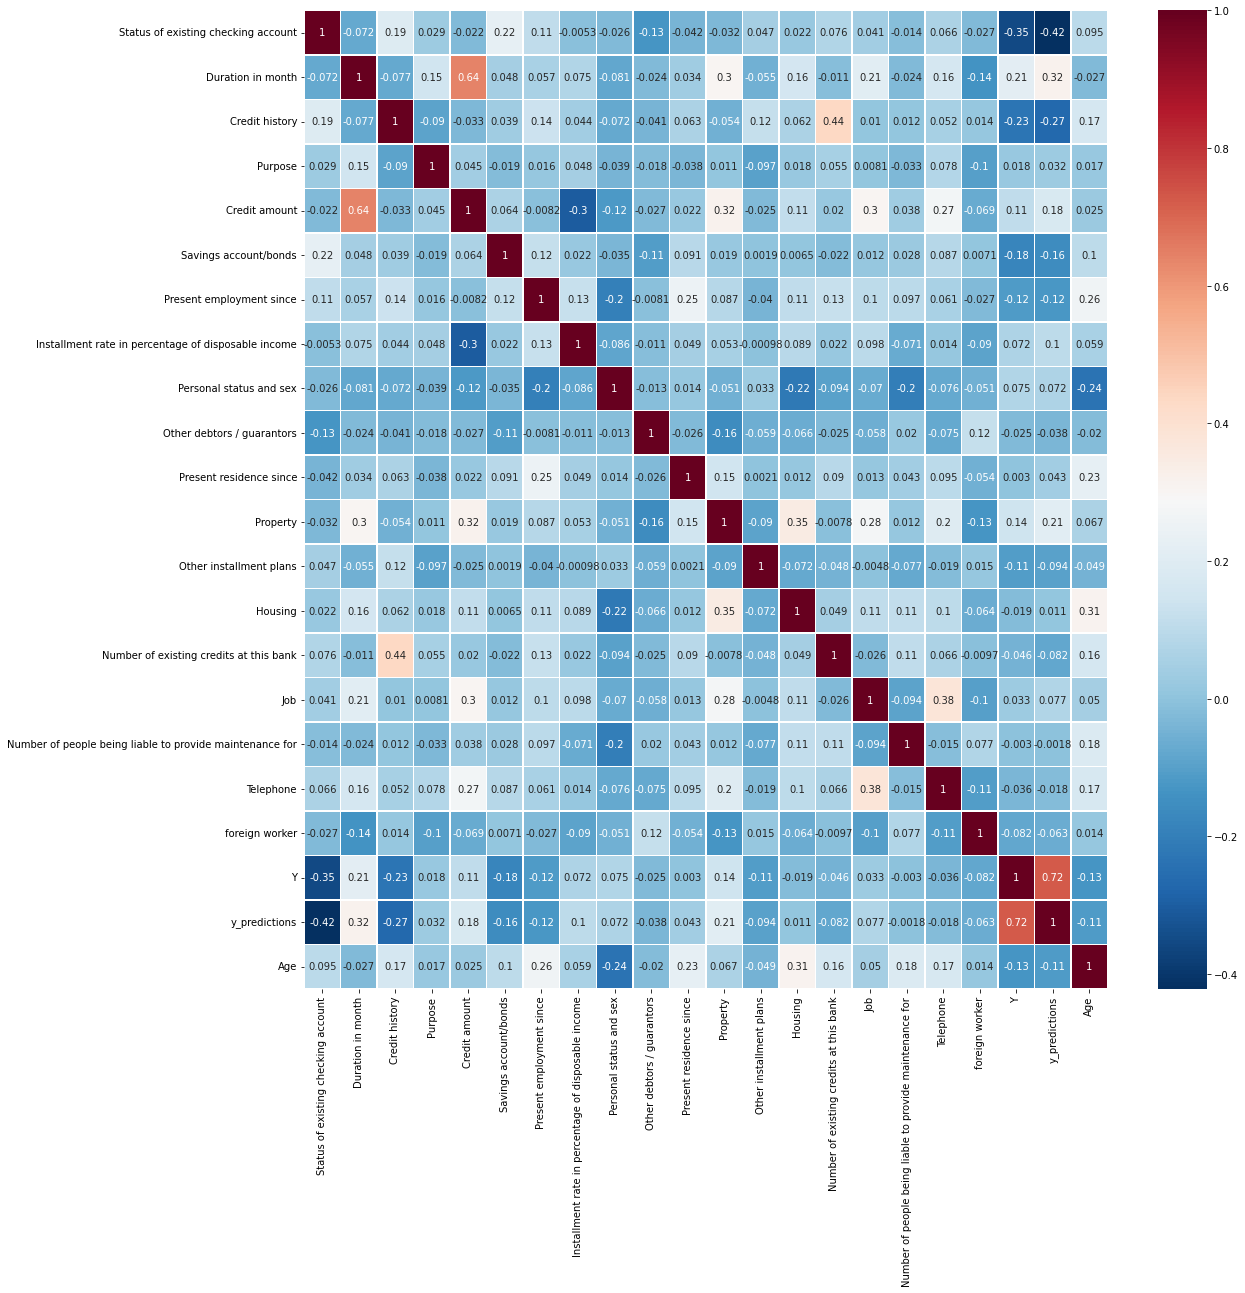

In [219]:
#Instead I will chart the correlation between different variables to ensure that there are no proxies for gender or age 
df_corr = pd.read_csv("german.data", header=None, delimiter=" ")
df_corr = df_corr.rename(columns={0: 'Status of existing checking account', 
                                      1: 'Duration in month', 
                                      2:'Credit history', 
                                      3:'Purpose', 
                                      4:'Credit amount', 
                                      5:'Savings account/bonds', 
                                      6: 'Present employment since',
                                      7:'Installment rate in percentage of disposable income', 
                                      8:'Personal status and sex', 
                                      9:'Other debtors / guarantors', 
                                      10:'Present residence since', 
                                      11:'Property', 
                                      12:'Age in years', 
                                      13:'Other installment plans', 
                                      14:'Housing', 
                                      15:'Number of existing credits at this bank', 
                                      16:'Job', 
                                      17:'Number of people being liable to provide maintenance for', 
                                      18:'Telephone', 
                                      19:'foreign worker', 
                                      20:'Y'})
#Add the predictions into the df: 
y_predictions = grid_search.predict(df_credit.to_numpy())
df_corr['y_predictions'] = y_predictions
#Take the log of credit var: 
df_corr['Credit amount'] = np.log(df_corr['Credit amount'])
#Bin Ages into Numeric Categories: 
interval = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df_corr["Age_cat"] = pd.cut(df_corr['Age in years'], interval, labels=cats)
df_corr['Age'] = df_corr['Age_cat'].replace(['Student', 'Young', 'Adult', 'Senior'],[0, 1, 2, 3])
del df_corr['Age in years']
del df_corr["Age_cat"]
#Status of existing checking account to Numeric categories 
df_corr['Status of existing checking account'] = df_corr['Status of existing checking account'].replace(['A11', 'A12', 'A13', 'A14'],[0, 1, 2, 3])
#Credit history to to Numeric categories
df_corr['Credit history'] = df_corr['Credit history'].replace(['A30', 'A31', 'A32', 'A33', 'A34'], [0, 1, 2, 3, 4])
#Purpose to Numeric categories
df_corr['Purpose'] = df_corr['Purpose'].replace(['A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A410'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#Savings account/bonds to Dummies Variable
df_corr['Savings account/bonds'] = df_corr['Savings account/bonds'].replace(['A61', 'A62', 'A63', 'A64', 'A65'], [0, 1, 2, 3, 4])
#Present employment since to Dummies Variable 
df_corr['Present employment since'] = df_corr['Present employment since'].replace(['A71', 'A72', 'A73', 'A74', 'A75'], [0, 1, 2, 3, 4])
#Personal status and sex to Dummies Variable 
df_corr['Personal status and sex'] = df_corr['Personal status and sex'].replace(['A91', 'A92', 'A93', 'A94', 'A95'], [0, 1, 0, 0, 1])
#Property to Dummies Variable
df_corr.Property = df_corr.Property.replace(['A121', 'A122', 'A123', 'A124'], [0, 1, 2, 3])
#Other installment plans to Dummies Variable
df_corr['Other installment plans'] = df_corr['Other installment plans'].replace(['A141', 'A142', 'A143'], [0, 1, 2])
#Housing to Dummies Variable
df_corr['Housing'] = df_corr['Housing'].replace(['A151', 'A152', 'A153'], [0, 1, 2])
#Job to Dummies Variable
df_corr['Job'] = df_corr['Job'].replace(['A171', 'A172', 'A173', 'A174'], [0, 1, 2, 3])
#Telephone to Dummies Variable
df_corr['Telephone'] = df_corr['Telephone'].replace(['A191', 'A192'], [0, 1])
#foreign worker to Dummies Variable 
df_corr['foreign worker'] = df_corr['foreign worker'].replace(['A201', 'A202'], [0, 1])
# 'Other debtors / guarantors' to Dummies Variable 
df_corr['Other debtors / guarantors'] = df_corr['Other debtors / guarantors'].replace(['A101', 'A102', 'A103'], [0, 1, 2])

pearsoncorr = df_corr.corr(method='pearson')

fig, ax = plt.subplots(figsize=(18,18))
 
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=.5,
            ax=ax)

In [229]:
#To check for Anti-Classification -- generate female to male results and check predictions

#Get indices from df that are female 
indices_of_female = (X_test[:,-22]).nonzero()
indices_of_female = list(indices_of_female[0].flatten())
fem_test = np.take(y_test, indices_of_female, 0)
fem_test = fem_test.to_list()
fem_pred = np.take(y_pred, indices_of_female, 0)
fem_pred = list(fem_pred)
newTest = X_test[fem_test]

#Change female one hot encoding to zero and change male to 1
newTest[:,-22] = 0
newTest[:,-21] = 1

#Get predictions on new fake male data 
y_predictions_male = grid_search.predict(newTest)
res = y_predictions_male == fem_pred

print("Percentage of discrepancies between female predictions and fake male data: ")
print((np.size(res) - np.count_nonzero(res))/np.size(res))

#To check for Anti-Classification -- generate student to elderly results and check predictions

#Get indices from df that are young 
indices_of_young = (X_test[:,-3]).nonzero()
indices_of_young = list(indices_of_young[0].flatten())
young_pred = np.take(y_pred, indices_of_young, 0)
young_pred = list(young_pred)
newTestYoung = X_test[indices_of_young]

#Change Young one hot encoding to zero and change senior to 1
newTestYoung[:,-3] = 0
newTestYoung[:,-1] = 1

#Get predictions on new fake senior data 
y_predictions_senior = grid_search.predict(newTestYoung)
res2 = y_predictions_senior == young_pred

print("Percentage of discrepancies between young predictions and fake senior data: ")
print((np.size(res2) - np.count_nonzero(res2))/np.size(res2))

Percentage of discrepancies between female predictions and fake male data: 
0.2328767123287671
Percentage of discrepancies between young predictions and fake senior data: 
0.0425531914893617


**Anti-classification Results**
To operationalize this metric, I decided to first try to calculate the accuracy on rows that were duplicated except for gender and age characteristics, however these rows did not exist. Instead, I calculated the Pearson's Correlation coefficient across all of the variables to determine whether gender and age had additional proxies that were causing multicolinearity in the model, or else, were causing age and gender to be considered in the model predictions multiple times. Calculating the Pearson's Correlation Coefficient over model predicted y values also inadvertently shows the significance of each variable in model predictions.

Based on the generated heatmap and correlation coefficients, it is clear that Age is slightly considered by the model when it calculates predictions, since there is a small correlation between age and prediction results (-.11). Housing is also moderately correlated with age at a coefficient of .3, meaning this could be treated as a proxy variable for age in the model's features. On the other hand, sex is not considered heavily by the model, with a coefficient of .072. The highest correlation sex has is with age, meaning these variables can have a compound impact on model predictions. Anti-classification is definitely not present in the current model based on these factors. To alleviate the model's consideration of protected categories, we need to remove these variables from consideration as well as the correlated variables. 

To further test the model for classification, I also generated random input data that only differed in age or gender to see if I was able to find inconsistencies in model predictions. To do this, I simply took the male data and changed the male designator to female and ran the data through the model. The percent change in model predictions was: 23.29% - meaning anti-classification is not present according to gender. I did the same thing to generate fake data points for age. The change in model predictions was: 4.25%, meaning the model does take this factor into account, but it does not have as much of an impact as gender. Anti-classification therefore does not exist for this protected category for the current model either. 

[Pearson Correlation Significance Chart](https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php)



---



---



**Group Fairness Testing:**

In [168]:
#Determine categories for each of the Gender and Age Columns 
indices_of_female = (X_test[:,-22]).nonzero()
indices_of_female = list(indices_of_female[0].flatten())
indices_of_male1 = (X_test[:,-21]).nonzero()
indices_of_male1 = list(indices_of_male1[0].flatten())
indices_of_male2 = (X_test[:,-20]).nonzero()
indices_of_male2 = list(indices_of_male2[0].flatten())
indices_of_male3 = np.argwhere((X_test[:,32] == 0) & (X_test[:,33] == 0) & (X_test[:,32] == 0))[0].flatten()
indices_of_male3 = list(indices_of_male3)
indices_of_male = []
indices_of_male.extend(indices_of_male1)
indices_of_male.extend(indices_of_male2)
indices_of_male.extend(indices_of_male3)
indices_of_young = (X_test[:,-3]).nonzero()
indices_of_young = list(indices_of_young[0].flatten())
indices_of_adult = (X_test[:,-2]).nonzero()
indices_of_adult = list(indices_of_adult[0].flatten())
indices_of_senior = (X_test[:,-1]).nonzero()
indices_of_senior = list(indices_of_senior[0].flatten())
indices_of_student = np.argwhere((X_test[:,-1] == 0) & (X_test[:,-2] == 0) & (X_test[:,-3] == 0))[0].flatten()
indices_of_student = list(indices_of_student)

In [169]:
#Show confusion matrix and accuracy for each Gender and Age Group
fem_test = np.take(y_test, indices_of_female, 0)
fem_test = fem_test.to_list()
fem_pred = np.take(y_pred, indices_of_female, 0)
fem_pred = list(fem_pred)
print("Predictions for female applicants: ")
print(accuracy_score(fem_test,fem_pred))
print(confusion_matrix(fem_test,fem_pred))
print("\n")

male_test = np.take(y_test, indices_of_male, 0)
male_test = male_test.to_list()
male_pred = np.take(y_pred, indices_of_male, 0)
male_pred = list(male_pred)
print("Predictions for male applicants: ")
print(accuracy_score(male_test,male_pred))
print(confusion_matrix(male_test,male_pred))
print("\n")

student_test = np.take(y_test, indices_of_student, 0)
student_test = student_test.to_list()
student_pred = np.take(y_pred, indices_of_student, 0)
student_pred = list(student_pred)
print("Predictions for student applicants: ")
print(accuracy_score(student_test, student_pred))
print(confusion_matrix(student_test, student_pred))
print("\n")

young_test = np.take(y_test, indices_of_young, 0)
young_test = young_test.to_list()
young_pred = np.take(y_pred, indices_of_young, 0)
young_pred = list(young_pred)
print("Predictions for young applicants: ")
print(accuracy_score(young_test, young_pred))
print(confusion_matrix(young_test, young_pred))
print("\n")

adult_test = np.take(y_test, indices_of_adult, 0)
adult_test = adult_test.to_list()
adult_pred = np.take(y_pred, indices_of_adult, 0)
adult_pred = list(adult_pred)
print("Predictions for adult applicants: ")
print(accuracy_score(adult_test, adult_pred))
print(confusion_matrix(adult_test, adult_pred))
print("\n")

senior_test = np.take(y_test, indices_of_senior, 0)
senior_test = senior_test.to_list()
senior_pred = np.take(y_pred, indices_of_senior, 0)
senior_pred = list(senior_pred)
print("Predictions for senior applicants: ")
print(accuracy_score(senior_test, senior_pred))
print(confusion_matrix(senior_test, senior_pred))

Predictions for female applicants: 
0.7123287671232876
[[43  8]
 [13  9]]


Predictions for male applicants: 
0.7721518987341772
[[103  13]
 [ 23  19]]


Predictions for student applicants: 
0.0
[[0 0]
 [1 0]]


Predictions for young applicants: 
0.7340425531914894
[[60  9]
 [16  9]]


Predictions for adult applicants: 
0.8043478260869565
[[62  5]
 [13 12]]


Predictions for senior applicants: 
0.5384615384615384
[[5 3]
 [3 2]]


In [245]:
#Group Fairness Calculation

print("Positive predictive value for female: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(fem_test,fem_pred).ravel()
print(tp/(fp+tp))
print("\n")


print("Positive predictive value for male: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(male_test,male_pred).ravel()
print(tp/(fp+tp))
print("\n")


print("Positive predictive value for student: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(student_test,student_pred).ravel()
print(tp, fp)
print(tp/(fp+tp))
print("\n")


print("Positive predictive value for young: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(young_test,young_pred).ravel()
print(tp/(fp+tp))
print("\n")


print("Positive predictive value for adult: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(adult_test,adult_pred).ravel()
print(tp/(fp+tp))
print("\n")


print("Positive predictive value for senior: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(senior_test,senior_pred).ravel()
print(tp/(fp+tp))

Positive predictive value for female: 
0.5294117647058824


Positive predictive value for male: 
0.59375


Positive predictive value for student: 
0 0
nan


Positive predictive value for young: 
0.5


Positive predictive value for adult: 
0.7058823529411765


Positive predictive value for senior: 
0.4


invalid value encountered in long_scalars


**Group Fairness Results**: To operationalize group fairness, I decided to use positive predictive value. This would be able to clearly show if the model was incorrectly learning that the protected attributes were good indicators for credit risk. The positive predictive rate for males and females was relatively close, so I would venture to say the model meets group fairness for this attribute. This is a much different story for age. There were no credit risk predictions for students, the most for adults, and the less for young and seniors. Since there is a large disparity in positive predictive values across these groups, group fairness is not met for the age criteria. 

In [247]:
#Separation Calculation 

#False positive rate: 
# FP/FP+TN

#False negative rate: 
# FN/FN + TN

print("False positive rate for female: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(fem_test,fem_pred).ravel()
print(fp/(fp+tn))
print("False negative rate for female: ")
print(fn/(fn+tn))
print("\n")

print("False positive rate for male: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(male_test,male_pred).ravel()
print(fp/(fp+tn))
print("False negative rate for male: ")
print(fn/(fn+tn))
print("\n")


print("False positive rate for student: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(student_test,student_pred).ravel()
print(fp/(fp+tn))
print("False negative rate for student: ")
print(fn/(fn+tn))
print("\n")


print("False positive rate for young: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(young_test,young_pred).ravel()
print(fp/(fp+tn))
print("False negative rate for young: ")
print(fn/(fn+tn))
print("\n")


print("False positive rate for adult: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(adult_test,adult_pred).ravel()
print(fp/(fp+tn))
print("False negative rate for adult: ")
print(fn/(fn+tn))
print("\n")


print("False positive rate for senior: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(senior_test,senior_pred).ravel()
print(fp/(fp+tn))
print("False negative rate for senior: ")
print(fn/(fn+tn))
print("\n")

False positive rate for female: 
0.1568627450980392
False negative rate for female: 
0.23214285714285715


False positive rate for male: 
0.11206896551724138
False negative rate for male: 
0.18253968253968253


False positive rate for student: 
nan
False negative rate for student: 
1.0


False positive rate for young: 
0.13043478260869565
False negative rate for young: 
0.21052631578947367


False positive rate for adult: 
0.07462686567164178
False negative rate for adult: 
0.17333333333333334


False positive rate for senior: 
0.375
False negative rate for senior: 
0.375




invalid value encountered in long_scalars


**Separation Results**: To operationalize separation, I chose to calculate the false positive and false negative rates for each of the protected attributes. The discrepancies between group false positive and false negative rates are not as apparent across genders. However, in the age groups, there is much less separation in the false negative rate, than there is across the false positive rate, which was .07, .37, .13, and NaN for each of the respective age categories. Thus, we can conclusively say there is separation across the age category in the model. 

**Task 3**: Improve model fairness: For one protected attribute of your choice and each of the three fairness measures, try to improve the fairness of your classifier and evaluate the impact on model accuracy. You will likely want to try different interventions depending on the fairness measure you try to improve. Examples of simple interventions include, eliminating the protected attribute for anti-classification, and tweaking thresholds for group fairness and separation. If you like, you can also explore more advanced interventions such as augmenting training data, preprocessing, or tweaking learning techniques, possibly with existing tools like IBM’s AI Fairness 360 toolkit.

In [263]:
# To improve anti-classification: 

# I simply removed the protected attributes and retrained the model without these attributes and recalculated accuracy: 

print("Accuracy before anti-classification changes: ")
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))

# Create Dataframe in Pandas and assign headers 

df_credit = pd.read_csv("german.data", header=None, delimiter=" ")
df_credit = df_credit.rename(columns={0: 'Status of existing checking account', 
                                      1: 'Duration in month', 
                                      2:'Credit history', 
                                      3:'Purpose', 
                                      4:'Credit amount', 
                                      5:'Savings account/bonds', 
                                      6: 'Present employment since',
                                      7:'Installment rate in percentage of disposable income', 
                                      8:'Personal status and sex', 
                                      9:'Other debtors / guarantors', 
                                      10:'Present residence since', 
                                      11:'Property', 
                                      12:'Age in years', 
                                      13:'Other installment plans', 
                                      14:'Housing', 
                                      15:'Number of existing credits at this bank', 
                                      16:'Job', 
                                      17:'Number of people being liable to provide maintenance for', 
                                      18:'Telephone', 
                                      19:'foreign worker', 
                                      20:'Y'})
#Status of existing checking account to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Status of existing checking account'], drop_first=True, prefix='Status of existing checking account'), left_index=True, right_index=True)
#Credit history to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Credit history'], drop_first=True, prefix='Credit history'), left_index=True, right_index=True)
#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Purpose'], drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Savings account/bonds to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Savings account/bonds'], drop_first=True, prefix='Savings account/bonds'), left_index=True, right_index=True)
#Present employment since to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Present employment since'], drop_first=True, prefix='Present employment since'), left_index=True, right_index=True)
#Property to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Property, drop_first=True, prefix='Property'), left_index=True, right_index=True)
#Other installment plans to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other installment plans'], drop_first=True, prefix='Other installment plans'), left_index=True, right_index=True)
#Housing to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
#Job to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Job, drop_first=True, prefix='Job'), left_index=True, right_index=True)
#Telephone to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Telephone, drop_first=True, prefix='Telephone'), left_index=True, right_index=True)
#foreign worker to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['foreign worker'], drop_first=True, prefix='foreign worker'), left_index=True, right_index=True)
# 'Other debtors / guarantors' to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other debtors / guarantors'], drop_first=True, prefix='Other debtors / guarantors'), left_index=True, right_index=True)
# 'Other installment plans' to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other installment plans'], drop_first=True, prefix='Other installment plans'), left_index=True, right_index=True)
# df_credit["Y"] to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Y'], drop_first=True, prefix='Y'), left_index=True, right_index=True)

y = df_credit.Y_2

#Remove now-redundant columns 
del df_credit['foreign worker']
del df_credit['Telephone']
del df_credit['Job']
del df_credit['Housing']
del df_credit['Property']
del df_credit['Personal status and sex']
del df_credit['Present employment since']
del df_credit['Savings account/bonds']
del df_credit['Purpose']
del df_credit['Credit history']
del df_credit['Status of existing checking account']
del df_credit['Other debtors / guarantors']
del df_credit['Other installment plans']
del df_credit['Age in years']
del df_credit['Y']
del df_credit['Y_2']

#Seting the Hyper Parameters
param_test1 = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

#Creating the classifier
model_xg = XGBClassifier(random_state=2)

grid_search = GridSearchCV(model_xg, param_grid=param_test1, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

# Verificaar os resultados obtidos
print("Accuracy after anti-classification changes: ")
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))

# Now reassess anti-classification fairness: 
indices_of_female = (X_test[:,-22]).nonzero()
indices_of_female = list(indices_of_female[0].flatten())
fem_test = np.take(y_test, indices_of_female, 0)
fem_test = fem_test.to_list()
fem_pred = np.take(y_pred, indices_of_female, 0)
fem_pred = list(fem_pred)
newTest = X_test[fem_test]

#Change female one hot encoding to zero and change male to 1
newTest[:,-22] = 0
newTest[:,-21] = 1

#Get predictions on new fake male data 
y_predictions_male = grid_search.predict(newTest)
res = y_predictions_male == fem_pred

print("Percentage of discrepancies between female predictions and fake male data: ")
print((np.size(res) - np.count_nonzero(res))/np.size(res))

Accuracy before anti-classification changes: 
0.756


[[155  23]
 [ 38  34]]
0.4908212560386473
{'colsample_bytree': 0.75, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.75}
Accuracy after anti-classification changes: 
0.756


[[155  23]
 [ 38  34]]
Percentage of discrepancies between female predictions and fake male data: 
0.2328767123287671


**Anti-classification report**: 
In order to improve this metric, I decided to remove gender and age from the model training. This was the most obvious approach to remove consideration of these variables.

As it turns out, removing gender and age does not affect the accuracy at all. The same exact model is trained, meaning that there likely exists proxy variables in the remainder of the dataset. Since this is the case, anti-classification still does not exist and the percentage of discrepancies remains the same. 

In [268]:
# To improve group fairness:

#We will train two separate models to optimize the parameters for accuracy on each gender 
indices_of_female = (X_train[:,-22]).nonzero()
indices_of_female = list(indices_of_female[0].flatten())
indices_of_male1 = (X_train[:,-21]).nonzero()
indices_of_male1 = list(indices_of_male1[0].flatten())
indices_of_male2 = (X_train[:,-20]).nonzero()
indices_of_male2 = list(indices_of_male2[0].flatten())
indices_of_male3 = np.argwhere((X_train[:,32] == 0) & (X_train[:,33] == 0) & (X_train[:,32] == 0))[0].flatten()
indices_of_male3 = list(indices_of_male3)
indices_of_male = []
indices_of_male.extend(indices_of_male1)
indices_of_male.extend(indices_of_male2)
indices_of_male.extend(indices_of_male3)

indices_of_female_test = (X_test[:,-22]).nonzero()
indices_of_female_test = list(indices_of_female_test[0].flatten())
indices_of_male1_test = (X_test[:,-21]).nonzero()
indices_of_male1_test = list(indices_of_male1_test[0].flatten())
indices_of_male2_test = (X_test[:,-20]).nonzero()
indices_of_male2_test = list(indices_of_male2_test[0].flatten())
indices_of_male3_test = np.argwhere((X_test[:,32] == 0) & (X_test[:,33] == 0) & (X_test[:,32] == 0))[0].flatten()
indices_of_male3_test = list(indices_of_male3_test)
indices_of_male_test = []
indices_of_male_test.extend(indices_of_male1_test)
indices_of_male_test.extend(indices_of_male2_test)
indices_of_male_test.extend(indices_of_male3_test)

#Seting the Hyper Parameters
param_test1 = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

#Creating the classifier female
model_xg_female = XGBClassifier(random_state=2)

grid_search_female = GridSearchCV(model_xg_female, param_grid=param_test1, cv=5, scoring='accuracy')
fem_pred_train = np.take(y_train, indices_of_female, 0)
fem_pred_train = list(fem_pred_train)
grid_search_female.fit(X_train[indices_of_female], fem_pred_train)

print(grid_search_female.best_score_)
print(grid_search_female.best_params_)

y_pred_female = grid_search.predict(X_test[indices_of_female_test])

#Creating the classifier male
model_xg_male = XGBClassifier(random_state=2)

grid_search_male = GridSearchCV(model_xg_male, param_grid=param_test1, cv=5, scoring='accuracy')
male_pred_train = np.take(y_train, indices_of_male, 0)
male_pred_train = list(male_pred_train)
grid_search_male.fit(X_train[indices_of_male], male_pred_train)

y_pred_male = grid_search.predict(X_test[indices_of_male_test])

0.7552304964539007
{'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8}


In [269]:
# Verificaar os resultados obtidos
print("Accuracy after group fairness changes Male Model: ")
y_test_male = np.take(y_train, indices_of_male_test, 0)
y_test_male = list(y_test_male)
print(accuracy_score(y_test_male, y_pred_male))
print("\n")
print(confusion_matrix(y_test_male, y_pred_male))

print("Accuracy after group fairness changes Female Model: ")
y_test_female = np.take(y_train, indices_of_female_test, 0)
y_test_female = list(y_test_female)
print(accuracy_score(y_test_female, y_pred_female))
print("\n")
print(confusion_matrix(y_test_female, y_pred_female))

Accuracy after group fairness changes Male Model: 
0.6329113924050633


[[88 20]
 [38 12]]
Accuracy after group fairness changes Female Model: 
0.684931506849315


[[44 11]
 [12  6]]


In [271]:
# Now reassess group fairness: 

#PREVIOUS FAIRNESS METRICS PRIOR TO CORRECTION MEASURES: 
# Predictions for female applicants: 
# 0.7123287671232876
# [[43  8]
#  [13  9]]

# Predictions for male applicants: 
# 0.7721518987341772

#FEMALE PREDICTIONS

#Group Fairness Calculation

print("Positive predictive value for female: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(y_test_female, y_pred_female).ravel()
print(tp/(fp+tp))
print("\n")


print("Positive predictive value for male: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(y_test_male, y_pred_male).ravel()
print(tp/(fp+tp))
print("\n")

Positive predictive value for female: 
0.35294117647058826


Positive predictive value for male: 
0.375




**Group Fairness report**: 
For this metric, I decided to train two separate models to try to adjust the threshold in accordance with the two separate genders as a secondary consequence. This threshold adjustment would ideally change the accuracy of each model in order to improve each gender metric individually so that they can converge on the same value. 

The positive predictive value for both female and male has decreased significantly. Changing the threshold inadvertently by optimizing two separate models for male and female groups actually decreased the accuracy of the model. The difference between the positive predictive values is the same: .02. This adjustment, therefore, did not work. 

In [274]:
#To improve separation: 

#Reduce separation in the dataset by removing highly-correlated features from the dataset 
#Based on confusion matrix and heatmaps charted above, I decided to drop Housing and Present Employment since 
#These two metrics had the highest correlation with Gender and Age respectively at .22 and .31 

# I will now drop these features and retrain the model to reduce separation


# Create Dataframe in Pandas and assign headers 

df_credit = pd.read_csv("german.data", header=None, delimiter=" ")
df_credit = df_credit.rename(columns={0: 'Status of existing checking account', 
                                      1: 'Duration in month', 
                                      2:'Credit history', 
                                      3:'Purpose', 
                                      4:'Credit amount', 
                                      5:'Savings account/bonds', 
                                      6: 'Present employment since',
                                      7:'Installment rate in percentage of disposable income', 
                                      8:'Personal status and sex', 
                                      9:'Other debtors / guarantors', 
                                      10:'Present residence since', 
                                      11:'Property', 
                                      12:'Age in years', 
                                      13:'Other installment plans', 
                                      14:'Housing', 
                                      15:'Number of existing credits at this bank', 
                                      16:'Job', 
                                      17:'Number of people being liable to provide maintenance for', 
                                      18:'Telephone', 
                                      19:'foreign worker', 
                                      20:'Y'})
#Status of existing checking account to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Status of existing checking account'], drop_first=True, prefix='Status of existing checking account'), left_index=True, right_index=True)
#Credit history to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Credit history'], drop_first=True, prefix='Credit history'), left_index=True, right_index=True)
#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Purpose'], drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Savings account/bonds to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Savings account/bonds'], drop_first=True, prefix='Savings account/bonds'), left_index=True, right_index=True)
#Property to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Property, drop_first=True, prefix='Property'), left_index=True, right_index=True)
#Other installment plans to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other installment plans'], drop_first=True, prefix='Other installment plans'), left_index=True, right_index=True)
#Job to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Job, drop_first=True, prefix='Job'), left_index=True, right_index=True)
#Telephone to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Telephone, drop_first=True, prefix='Telephone'), left_index=True, right_index=True)
#foreign worker to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['foreign worker'], drop_first=True, prefix='foreign worker'), left_index=True, right_index=True)
# 'Other debtors / guarantors' to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other debtors / guarantors'], drop_first=True, prefix='Other debtors / guarantors'), left_index=True, right_index=True)
# 'Other installment plans' to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Other installment plans'], drop_first=True, prefix='Other installment plans'), left_index=True, right_index=True)
# df_credit["Y"] to Dummies Variable 
df_credit = df_credit.merge(pd.get_dummies(df_credit['Y'], drop_first=True, prefix='Y'), left_index=True, right_index=True)

y = df_credit.Y_2

#Remove now-redundant columns 
del df_credit['foreign worker']
del df_credit['Telephone']
del df_credit['Job']
del df_credit['Housing']
del df_credit['Property']
del df_credit['Personal status and sex']
del df_credit['Present employment since']
del df_credit['Savings account/bonds']
del df_credit['Purpose']
del df_credit['Credit history']
del df_credit['Status of existing checking account']
del df_credit['Other debtors / guarantors']
del df_credit['Other installment plans']
del df_credit['Age in years']
del df_credit['Y']
del df_credit['Y_2']

#Seting the Hyper Parameters
param_test1 = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

#Creating the classifier
model_xg = XGBClassifier(random_state=2)

grid_search = GridSearchCV(model_xg, param_grid=param_test1, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

# Verificaar os resultados obtidos
print("Accuracy after anti-classification changes: ")
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))

0.4908212560386473
{'colsample_bytree': 0.75, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.75}
Accuracy after anti-classification changes: 
0.756


[[155  23]
 [ 38  34]]


In [277]:
# Re-calculate separation:

# Start by retrieving the group indices for male and female 
indices_of_female_test = (X_test[:,-22]).nonzero()
indices_of_female_test = list(indices_of_female_test[0].flatten())
indices_of_male1_test = (X_test[:,-21]).nonzero()
indices_of_male1_test = list(indices_of_male1_test[0].flatten())
indices_of_male2_test = (X_test[:,-20]).nonzero()
indices_of_male2_test = list(indices_of_male2_test[0].flatten())
indices_of_male3_test = np.argwhere((X_test[:,32] == 0) & (X_test[:,33] == 0) & (X_test[:,32] == 0))[0].flatten()
indices_of_male3_test = list(indices_of_male3_test)
indices_of_male_test = []
indices_of_male_test.extend(indices_of_male1_test)
indices_of_male_test.extend(indices_of_male2_test)
indices_of_male_test.extend(indices_of_male3_test)
indices_of_female = (X_test[:,-22]).nonzero()
indices_of_female = list(indices_of_female[0].flatten())
fem_test = np.take(y_test, indices_of_female_test, 0)
fem_test = fem_test.to_list()
fem_pred = np.take(y_pred, indices_of_female_test, 0)
fem_pred = list(fem_pred)
male_test = np.take(y_test, indices_of_male_test, 0)
male_test = male_test.to_list()
male_pred = np.take(y_pred, indices_of_male_test, 0)
male_pred = list(male_pred)

#Separation Re-Calculation 

#False positive rate: 
# FP/FP+TN

#False negative rate: 
# FN/FN + TN

print("False positive rate for female: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(fem_test,fem_pred).ravel()
print(fp/(fp+tn))
print("False negative rate for female: ")
print(fn/(fn+tn))
print("\n")

print("False positive rate for male: ")
#calculate value from confusion matrix: 
tn, fp, fn, tp = confusion_matrix(male_test,male_pred).ravel()
print(fp/(fp+tn))
print("False negative rate for male: ")
print(fn/(fn+tn))
print("\n")

False positive rate for female: 
0.1568627450980392
False negative rate for female: 
0.23214285714285715


False positive rate for male: 
0.11206896551724138
False negative rate for male: 
0.18253968253968253




**Separation report**: I tried to improve separation by removing variables that were correlated with sex and gender. I removed the most highly correlated variables and each respective protected attribute.

The false positive and negative rates did not change at all for either female or male groups. This may be because there are non-linear relationships between the variables that the model is capturing. 

**Task 4**: Fairness properties: Discuss which fairness property may be suitable in the credit rating setting and why. If you could only enforce one fairness property, which one would it be?

Each fairness metric comes with its own set of pros and cons. The anti-classification metric in particular, by virtue of not including protected attributes, promotes equity above all else. This is a fairness mindset that many have, however this comes at the expense of equality, which recognizes the disadvantages that people face based on their age, gender, etc. and attempts to offer the same opportunities equally across groups in spite of these disadvantages. This is the major tradeoff that anti-classification presents: the inability to offer disadvantaged groups different thresholds and offer an equal playing field. Anti-classification metrics in the case of credit risk, can inadvertently continue to discriminate against women and minorities because it never recognizes that many other attributes are linked to these factors or that these groups need to have different thresholds to improve equal access to credit. The goal of this model is equity: ensuring that the model is not able to detect protected attributes and each person has the same opportunity without regard for their circumstances or disadvantages. 

Group fairness, on the other hand, can allow developers to falsely categorize random individuals with positive outcomes instead of incentivizing the engineering of better models. The positives of this model are, that individuals from disadvantaged groups who may not be considered by a general model, but still would not default on a loan, can be considered and categorized with equality in mind. The goal of this metric is to provide equality: ensuring that each group of people has a similar rate of opportunity, and thus, inadvertently paying homage to the circumstances and disadvantages they faced leading up to the moment of decision.  

Separation also has its own pros and cons. For one, separation undervalues the true positive results. When models need to detect very rare diseases, etc., this could needlessly discriminate against a model that benefits most from a high true positive rate. On the other side, this metric is best for cases where false positives and/or negatives can cause people harm, and thus the model must to be aggressively trained to optimize against these errors. The goal of separation is to ensure that false positives and negatives are minimized. In the case of credit risk, this means that the risk of misclassifying a person as a good risk when they are bad is low, as well as the risk of misclassifying them as a bad risk when they are good is low. 

I would select separation as the metric. False negatives can greatly harm individuals who are in need of a loan, but the model denies incorrectly. This impacts their standard of living and potential to become homeowners/business owners/car owners. On the other hand, false positives result in the lending company losing an exorbitant amount of money and lost opportunity from interest. These are two extremes that the model should be safeguarded against: causing harm to others and loss of revenue for the lending company. 


**Task 5**: Fairness in movie recommendation: Consider whether the recommendation algorithm of the group project (in its current for or with possible extensions) has potential fairness issues. Assume that movie ratings users make are public to all other users. Consider not only legal issues but also potential ethical issues.

Discuss possible harms (harms of allocation and harms of representation) the model may cause for users or other stakeholders, or discuss why such harms are unlikely. Be explicit about the groups or protected attributes you are considering, which may include attributes of users or of movies.
Discuss possible sources of bias (at least: skewed samples, tainted examples, limited features, sample size disparity, and proxies) that may lead to unfair recommendations, and whether they are relevant in the movie recommendation setting.
Make a suggestion for fairness-related practices you might adopt throughout the life cycle of this project. In particular, your suggestion should describe practices pertaining to at least one of the following activities: (1) data collection and pre-processing for fairness, (2) selection of a fairness critera to train the model, and (3) monitoring the system for biased outcome and deploying an escalation plan. Briefly justify your answer. If you recommend not to take any action, justify this decision too. You do not need to actually implement any practices within this course, now or later, but attempt to make recommendations that could realistically be considered in a startup competing with Netflix.

10 points: A discussion of harms of representation and harms of allocation and corresponding groups/protected attributes in the context of the movie recommendation example is included.
 10 points: A discussion of the five sources of bias in the context of the movie recommendation example is included.
 10 points: The report includes a justified recommendation of at least one engineering practice (which can be one of (1) data collection & pre-processing, (2) fairness criteria selection and (3) monitoring & escalation) or a justification why no practice shall be adopted. The recommendation and justifications are grounded in the realism of the movie recommendation scenario.

1. **Harms of representation/allocation etc.**: I would consider race, gender, and age as protected attributes. 

I would consider children as a special sub-population in particular within the age category. Gender is a protected category because we want to avoid showing women only romantic comedies or Hallmark movies and only showing educational content and documentaries to male viewers. This perpetuates stereotypes against women and their preferences that could result in negative self-image across women and lost educational opportunities (harm of representation). Because there is less educational content available to these women, this results in a harm of representation, where women, constantly being exposed only to shallow content, begin to view themselves as less in society. The harm of allocation exists when women are denied the initial opportunity to see the type of content they prefer, in this case documentaries, which is more of a transactional harm.

This carries over to minority groups as well. We do not want to only recommend movies which actors that share the viewer's race. This causes a lack of valuable diversity across viewers and lost opportunity for quality content that viewers would enjoy despite this difference. The harm of allocation in this case is that individuals who would have really enjoyed a movie made by people of a different race, are not recommended this movie and it never appears on their screen, causing them to lose out on this enjoyable experience. The harm of representation runs much deeper. Because movie recommendations are essentially segregated, racism and prejudice remain major undertones in society and children grow up with the concept of "othering" people of different races. 

I would also consider age as a protected attribute, but with children as an unprotected separate binary feature in the dataset. By keeping age protected, we can avoid recommending only brand new movies to younger generations and vice a versa, when generational diversity can be very valuable in terms of educational value and exposure to unique cinematic techniques. The harm of allocation in this case is similar to the aforementioned ones. Elderly people do not have access to fresh content because the movie recommendation system assumes they are only interested in decades-old content, and they miss out on being able to see the new movie they wanted to see. The harm of representation, however, is that this constant denial of fresh content to the elderly causes them to constantly remain "out of the loop," missing pop culture references and they grow to be outcasts in society, discarded as old relics. 

2. **Five sources of bias**: 

A. *Skewed samples*: Skewed samples could occur if females primarily select romantic comedies in historical data that the company has collected. They rarely choose documentaries and the opposite is true for males. Most women choose romantic comedies but there are occasions in which they choose something else to watch. Skew can certainly be the case in movie recommendations because society encourages certain preferences based on gender and race, which is difficult to overcome. 

B. *Tainted examples*: These examples occur from data poisoning, which happens when an attacker inserts false data into the model to distort predictions and reduce accuracy. This is a risk for movie recommendation companies. There are many competitors who would like to reduce the capabilities of Netflix, etc. by disabling their ability to generate good recommendations and thereby encouraging customers to use their streaming service instead. These attacks must be safeguarded against with the security protocols we learned about in lecture. 

C. *Limited features*: This occurs when a new user enters the movie recommendation platform and all we know about them is their name, address, and payment method. Until they continue to use the platform, rate movies, engage with content, etc., we won't be able to generate quality recommendations. When a movie recommendation platform is first launched, this is true across the entire platform. It must be mitigated possibly through general-populace recommendations that are most-likely to work for every one until more data can be gathered. 

D. *Sample size disparity*: This occurs when there is a very small amount of users engaging with the platform within a certain race, country, gender, or age-group. Because this is the case, it is difficult to generalize your recommendations from that small sample to the remainder of that sub-population. This can be mitigated through the generation of additional data points artificially, or by marketing the platform more heavily to these subpopulations to improve the platform's diversity and amount of data for this sub-population. 

E. *Proxies*: This occurs when there are features in the data that are highly correlated with protected attributes. Height is highly correlated with gender, so including both in a model results in multi-collinearity, poor model training, and unexpected/biased predictions. For movie recommendations, this can be the user's address and payment type may be highly correlated features indicating their income level. Including these features should not be relevant to the movie recommendations, but certainly both should not be included. This can occur in movie recommendations when we do not carefully preprocess the data, conduct our pre-processing correlation statistics, and drop correlated variables prior to training the model. 



3. **One engineering practice**: I would use the re-weighing technique present in AIF360 to reduce the bias in the dataset. This is a preprocessing technique that takes a sample of data that is imbalanced across its prtected attributes, and re-weights the examples in each (group, label) pair differently to ensure fairness before classification. I think this metric is particularly helpful when there are many under-represented groups present. In the case of a movie recommendation system, which is ever-expanding to new countries. The people from the new countries could be unfairly discriminated against in the recommendations if their smaller sample-size isn't adjusted for in the pre-processing stages. I would also remove features that are highly correlated with any of the protected attributes, to reduce their effect on movie recommendations. This would likely inprove group fairness as a result. I think these pre-processsing techniques are key because a model is only as good and fair as its data, so if we take care to ensure that the data is properly cleaned and processed prior to model training and architecture development, we can improve our chances of devising a truly fair model. If you instead choose a post-processing technique, such as thresholding, you are still inevitably stuck with a biased model that you are just artificially obscuring. 
